### KNN Model – Geospatial Gun Violence Analysis

#### Importing Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier #https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbours/
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

#### Loading and Preparing the Dataset

In [2]:
data = pd.read_csv("GVA_w-injury_2015_2021apr_geocoded.csv")
data = data.rename(columns={"X": "longitude", "Y": "latitude"})
data['n_killed'] = data['n_killed'].fillna(0)
data['n_injured'] = data['n_injured'].fillna(0)

#### Creating GeoDataFrame and Setting Coordinate Reference System

In [3]:
data = data.drop(columns=['state', 'city_or_county', 'address', 'incident_url', 'source_url'])

gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

#### Calculating Distance to Nearest Point

In [4]:
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
tree = cKDTree(coords)
distances, indices = tree.query(coords, k=2)
gdf['dist_to_nearest'] = distances[:, 1]

buffer_radius = 2000

#### Calculating Local Neighborhood Statistics (2 km Radius)

In [5]:
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
tree = cKDTree(coords)
buffer_radius = 2000 


coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
tree = cKDTree(coords)
buffer_radius = 2000

gdf['count_2km'] = gdf.geometry.apply(
    lambda point: len(tree.query_ball_point([point.x, point.y], r=buffer_radius)) - 1
)

def mean_in_radius(point, radius=buffer_radius):
    neighbors_idx = tree.query_ball_point([point.x, point.y], r=radius)
    neighbors = gdf.iloc[neighbors_idx]
    return pd.Series({
        'mean_killed_2km': neighbors['n_killed'].mean(),
        'mean_injured_2km': neighbors['n_injured'].mean()
    })

gdf[['mean_killed_2km','mean_injured_2km']] = gdf.geometry.apply(lambda pt: mean_in_radius(pt))


#### Defining Features and Splitting Data for Risk Classification

In [6]:
gdf['risk_level'] = ((gdf['n_killed'] > 0) | (gdf['n_injured'] >= 3)).astype(int)
feature_cols = ['latitude', 'longitude', 'month', 'year', 'dist_to_nearest', 'count_2km']
X = gdf[feature_cols]
y = gdf['risk_level']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=53)

#### Training K-Nearest Neighbors Classifier

In [7]:
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    n_jobs=-1
)
knn.fit(X_train, y_train)

,n_neighbors,15
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


#### Evaulating accuracy

In [8]:
preds = knn.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, preds))

Validation Accuracy: 0.5870784663103016


##### The accuracy of KNN model on predictions are pretty high with 58.7%

#### Defining a Function to Predict Safety Risk at a Given Location

In [9]:
def predict_safety(lat, lon, month, year):
    point = Point(lon, lat)
    point_proj = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(epsg=3857)
    x, y_ = point_proj.geometry.x.iloc[0], point_proj.geometry.y.iloc[0]

    dist, idx = tree.query([(x, y_)], k=2)
    dist_to_nearest = dist[0][1]

    count_2km = len(tree.query_ball_point((x, y_), r=buffer_radius)) - 1

    X_new = pd.DataFrame([{
        'latitude': lat,
        'longitude': lon,
        'month': month,
        'year': year,
        'dist_to_nearest': dist_to_nearest,
        'count_2km': count_2km
    }])
    pred = knn.predict(X_new)[0]
    return "HIGH RISK" if pred == 1 else "LOW RISK"

#### Visualizing Local Gun Violence Risk Around a Target Location

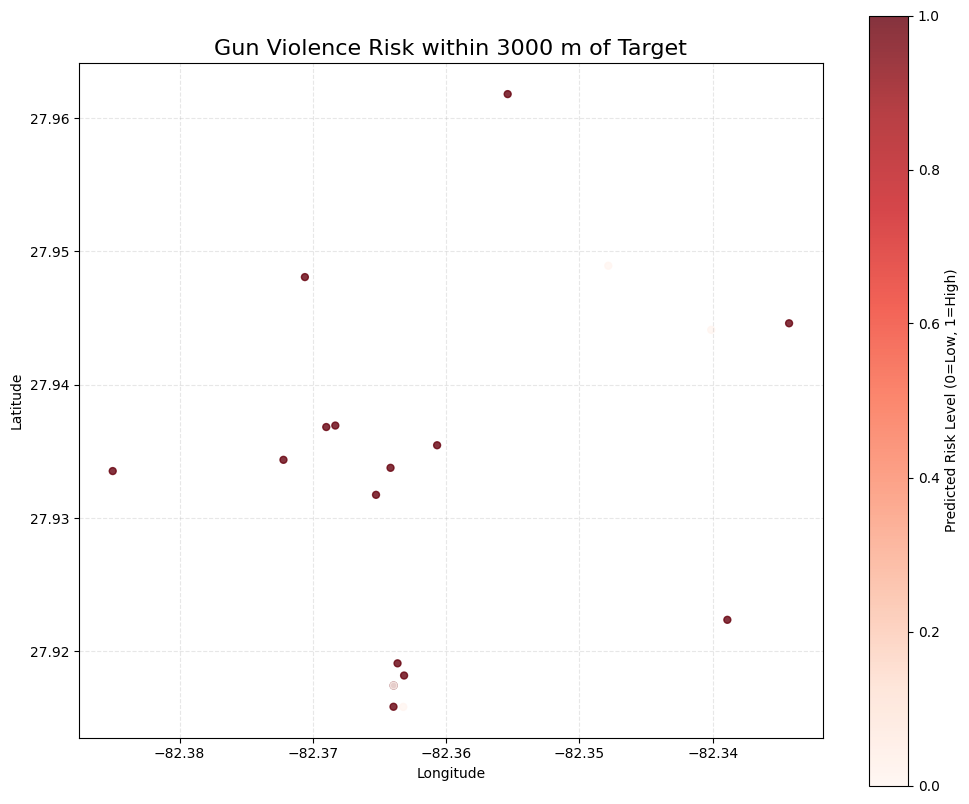

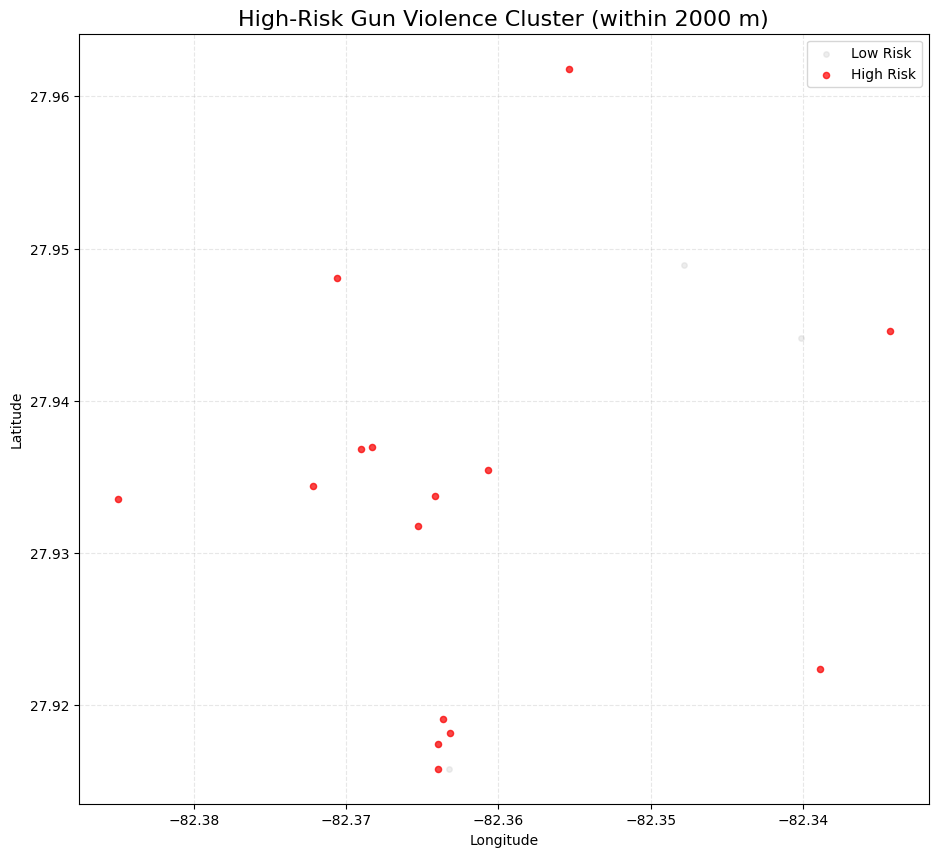

In [10]:
target_lon, target_lat = -82.36067825899994, 27.935466268000027
radius = 3000
projected_crs = "EPSG:26918"

gdf = gdf.to_crs(projected_crs)

target_point = gpd.GeoSeries(
    gpd.points_from_xy([target_lon], [target_lat]),
    crs="EPSG:4326"
).to_crs(projected_crs)

target_buffer = target_point.buffer(radius).iloc[0]

local_gdf = gdf[gdf.geometry.intersects(target_buffer)].copy()

if local_gdf.empty:
    raise ValueError(f"No points found within {radius} meters of target location.")

local_gdf["pred_risk"] = knn.predict(local_gdf[feature_cols])

local_gdf_plot = local_gdf.to_crs(epsg=4326)

plt.figure(figsize=(12,10))
plt.scatter(
    local_gdf_plot.geometry.x,
    local_gdf_plot.geometry.y,
    c=local_gdf_plot["pred_risk"],
    cmap="Reds",
    s=25,
    alpha=0.8
)
plt.colorbar(label="Predicted Risk Level (0=Low, 1=High)")
plt.title(f"Gun Violence Risk within {radius} m of Target", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.3)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

high_risk_gdf = local_gdf_plot[local_gdf_plot["pred_risk"] == 1]

plt.figure(figsize=(12,10))
plt.scatter(
    local_gdf_plot.geometry.x,
    local_gdf_plot.geometry.y,
    color="lightgrey",
    s=15,
    alpha=0.4,
    label="Low Risk"
)
plt.scatter(
    high_risk_gdf.geometry.x,
    high_risk_gdf.geometry.y,
    color="red",
    s=20,
    alpha=0.7,
    label="High Risk"
)
plt.title(f"High-Risk Gun Violence Cluster (within {buffer_radius} m)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()